# Image Inpainting with cVAE

In [54]:
import torch
import torchvision
from models.cvae2 import cVAE
from datasets import celeba
from matplotlib import pyplot as plt
from datasets.inpainting import DeleteRandomRectangle, DeleteRectangle, DeleteSmilingRectangle

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
def crop(x, low, high):
    x[x <= low] = low
    x[x >= high] = high
    return x

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: crop(x, 0., 1.)),
    torchvision.transforms.Resize((109, 89), antialias=True),  # (3, 218, 178) -> (3, 109, 89)
    torchvision.transforms.CenterCrop((64, 64)),
])

train_data = celeba.CelebA(root='C:/Datasets/', download=False, transform=transform)


In [71]:
def display_reconstruction(generator, img_index, deletion, labels = [0,1]):
    img, _ = train_data[img_index]

    plt.figure(figsize=(15,15))

    num_pics = 2 + len(labels)*2

    plt.subplot(1, num_pics, 1)
    plt.imshow(img.squeeze().permute(1,2,0))

    cropped, mask = deletion(img.unsqueeze(0))
    plt.subplot(1, num_pics, 2)
    plt.imshow(cropped.squeeze().permute(1,2,0))
    
    for i, label in enumerate(labels):
        generated, _, _ = generator(cropped.to(device), torch.tensor([label], device=device))
        generated = generated.cpu().detach()
        plt.subplot(1, num_pics, 2 + 2*i + 1)
        plt.imshow(generated.squeeze().permute(1,2,0))
        
        result = img * (1 - mask) + generated * mask
        plt.subplot(1, num_pics, 2 + 2*i + 2)
        plt.imshow(result.cpu().detach().squeeze().permute(1,2,0))
    
    plt.show()

## Inpainting smiles

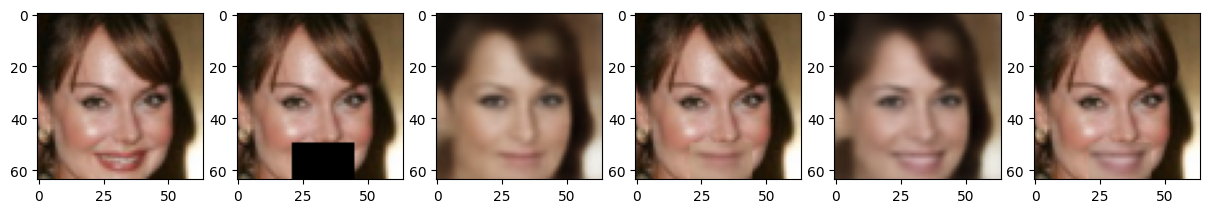

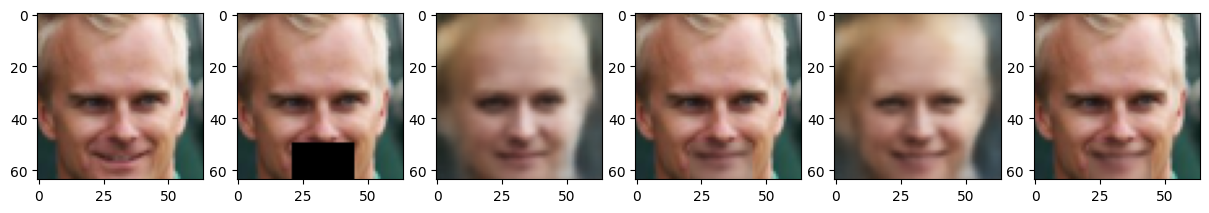

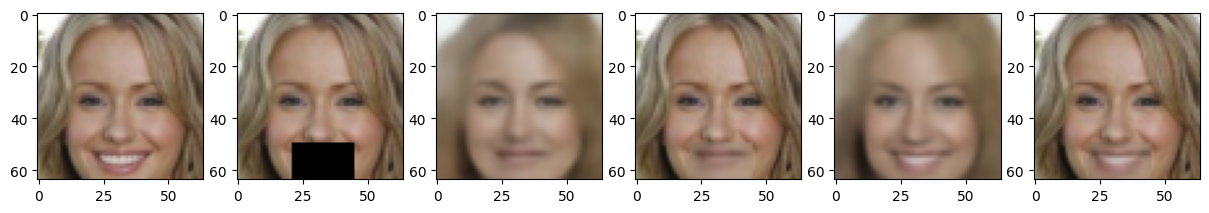

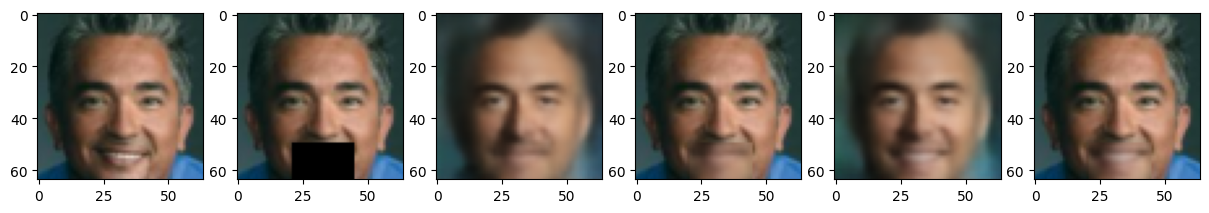

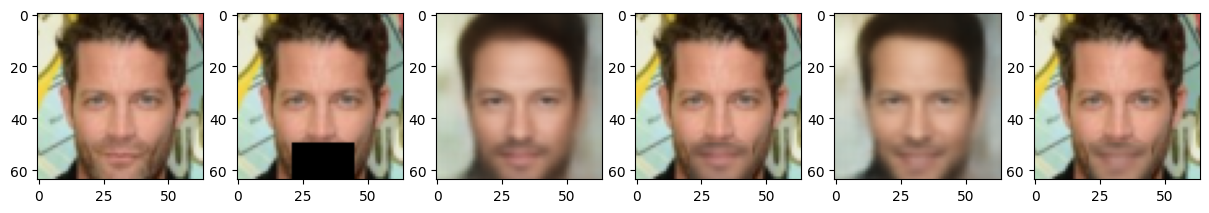

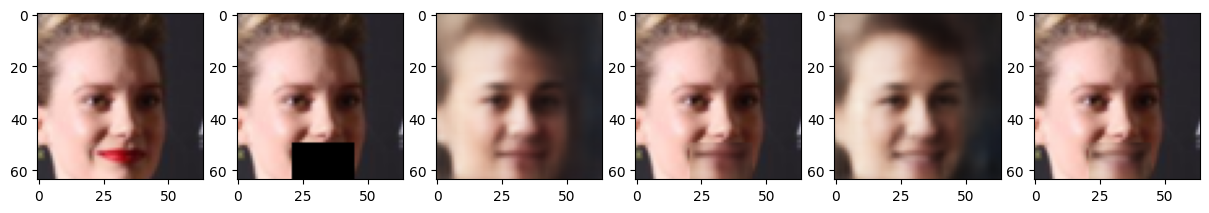

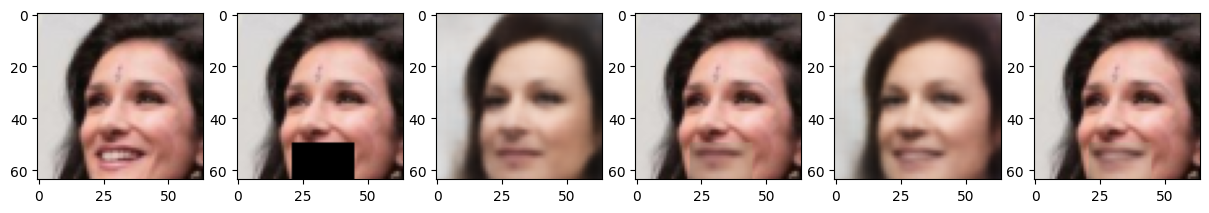

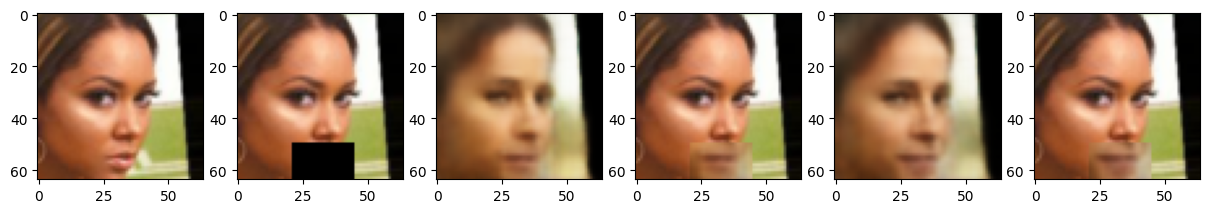

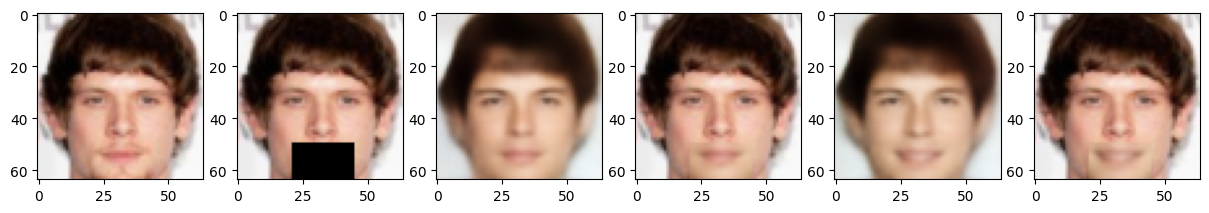

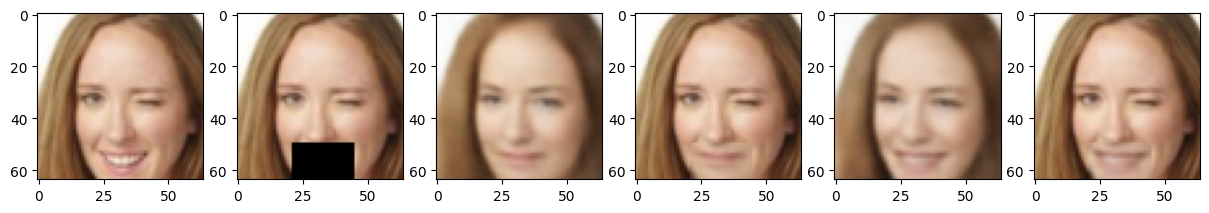

In [72]:
# Baseline cVAE

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/smiling-inpainter-baseline.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

deletion = DeleteSmilingRectangle()

for img_index in [8,12,53,1256,1212,99,231,613,71316,131313]:
    display_reconstruction(model, img_index, deletion)

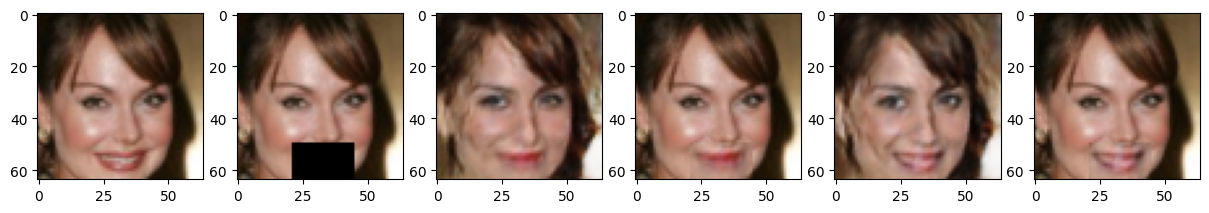

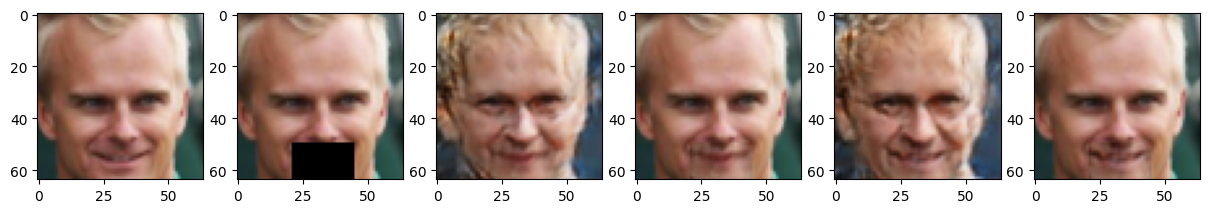

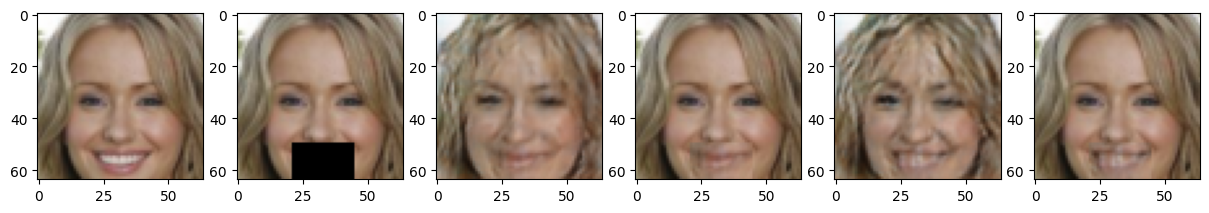

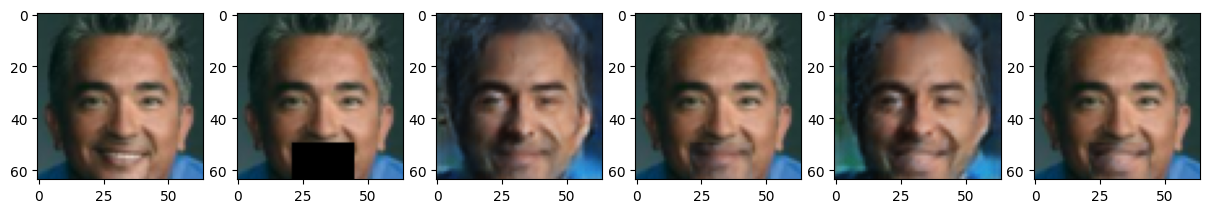

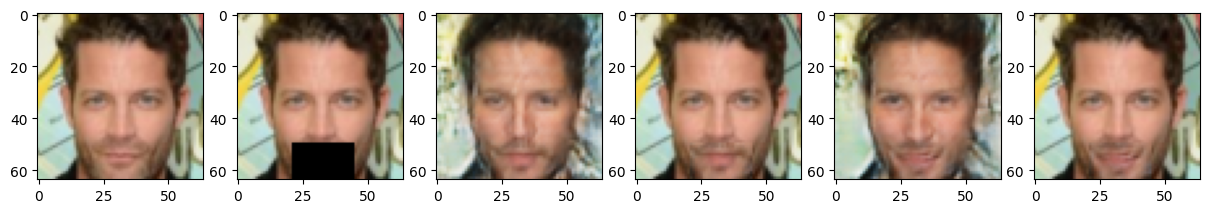

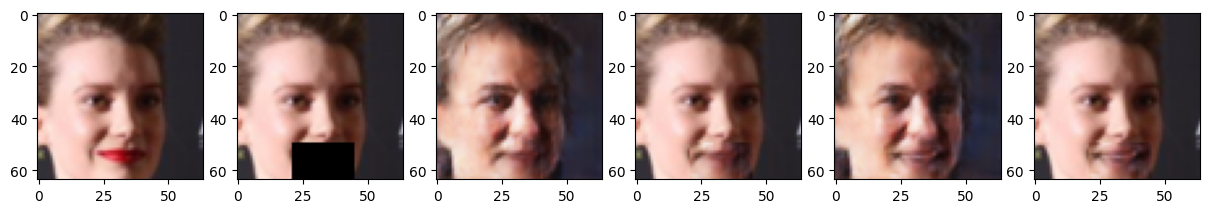

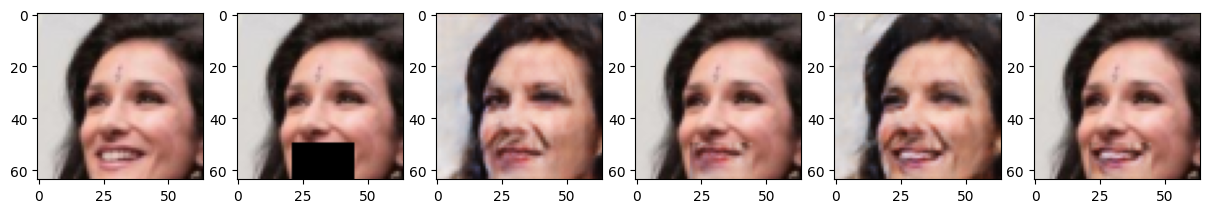

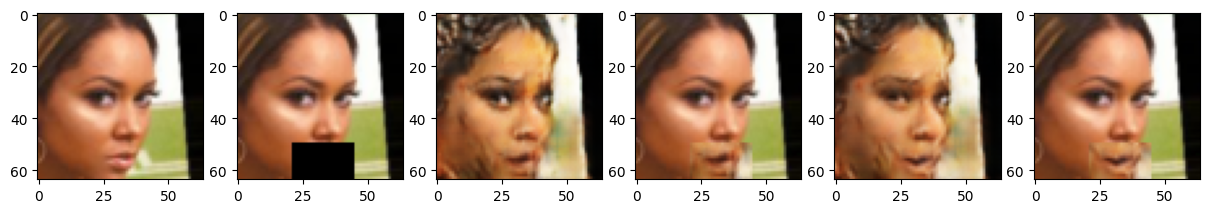

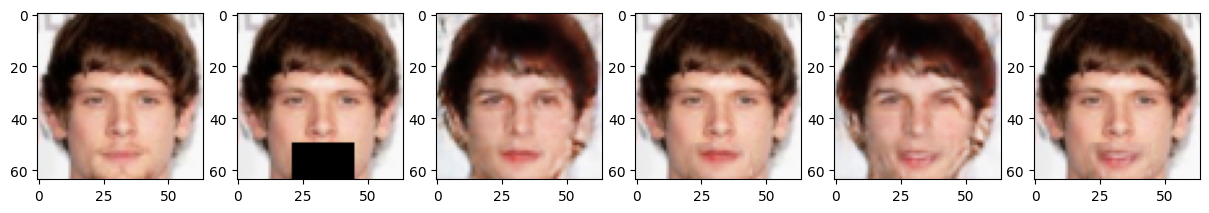

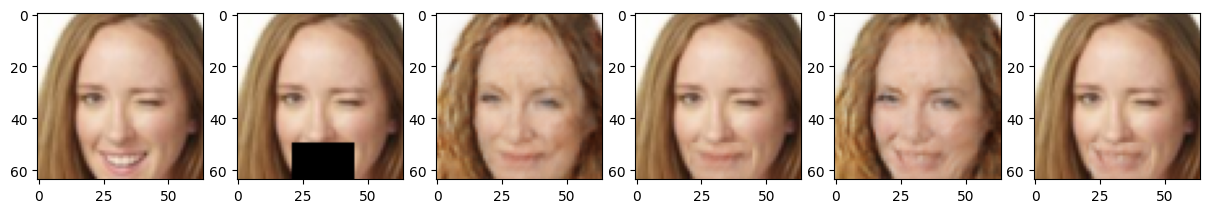

In [66]:
# cVAE finetuned with adversarial loss

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/smiling-inpainter.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

deletion = DeleteSmilingRectangle()

for img_index in [8,12,53,1256,1212,99,231,613,71316,131313]:
    display_reconstruction(model, img_index, deletion)

## General inpainting with no attributes

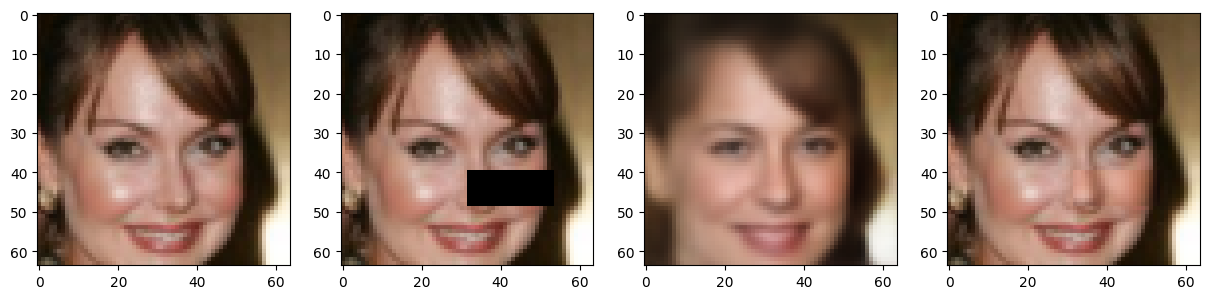

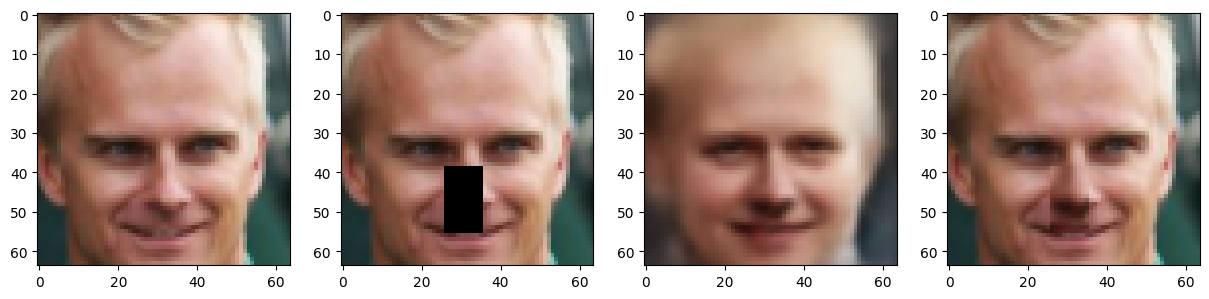

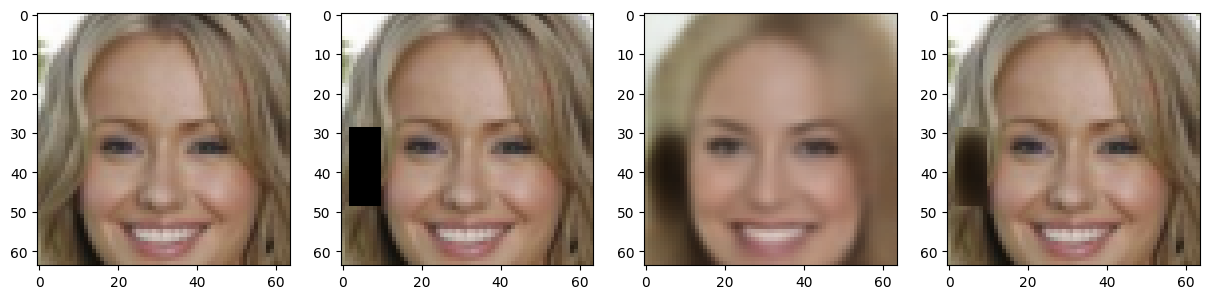

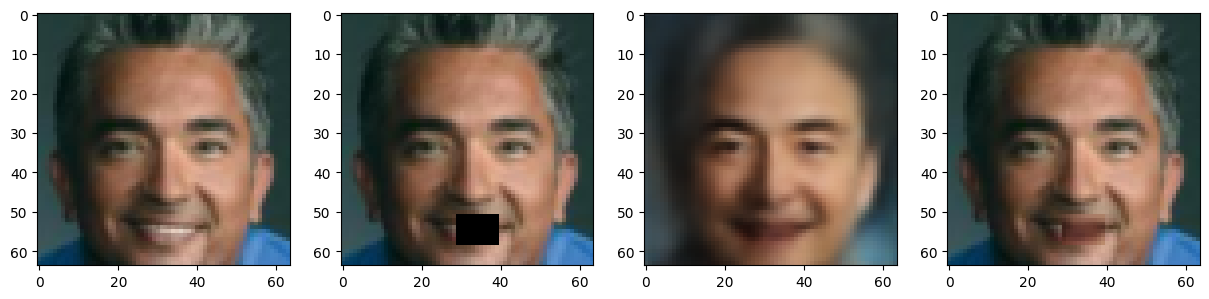

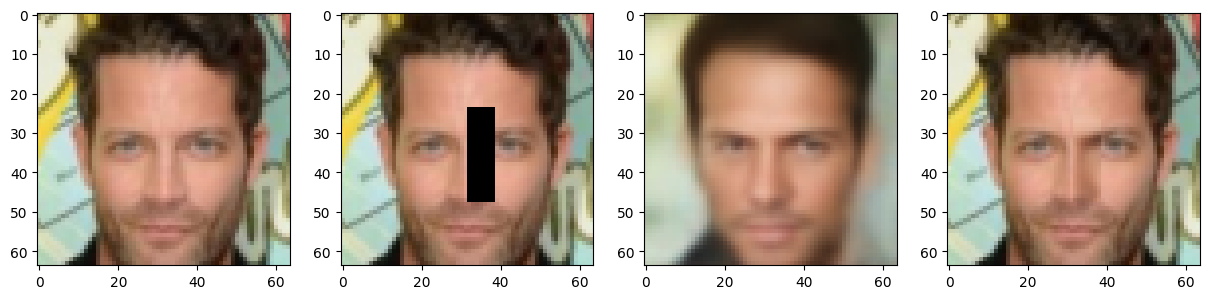

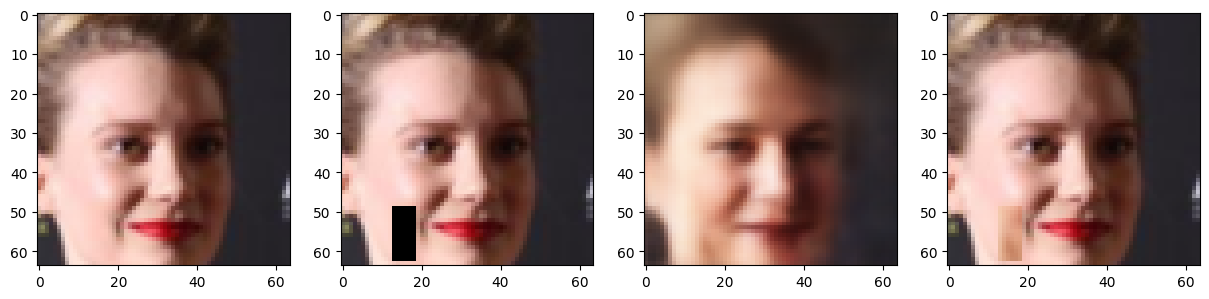

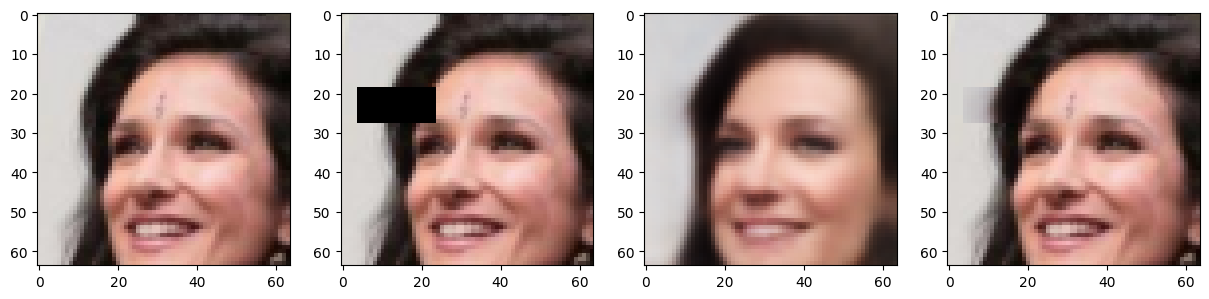

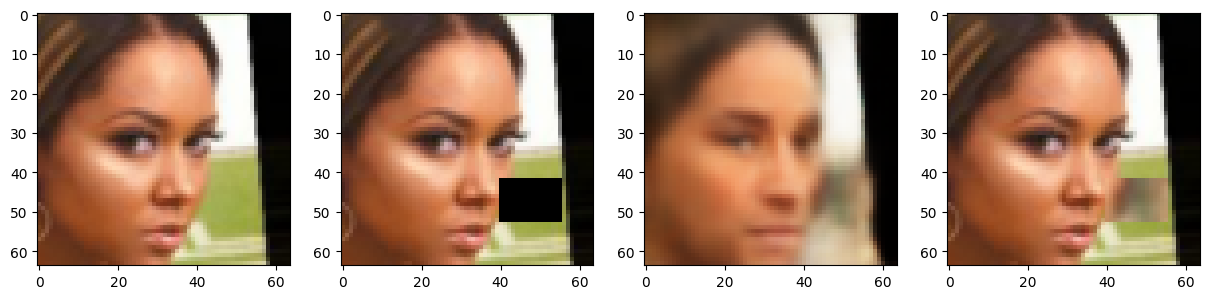

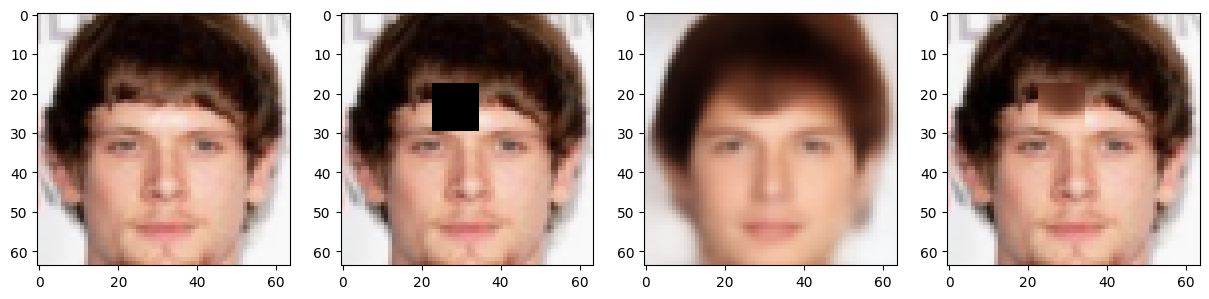

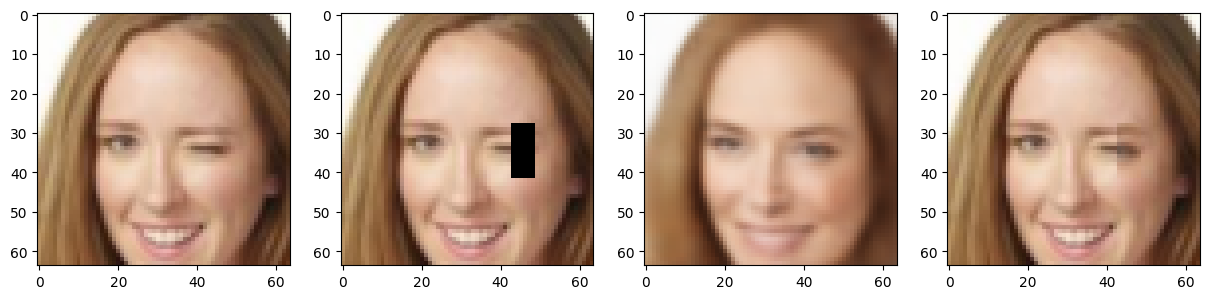

In [76]:
# Baseline cVAE

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/general-inpainter-baseline.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

deletion = DeleteRandomRectangle()

for img_index in [8,12,53,1256,1212,99,231,613,71316,131313]:
    display_reconstruction(model, img_index, deletion, labels=[0])

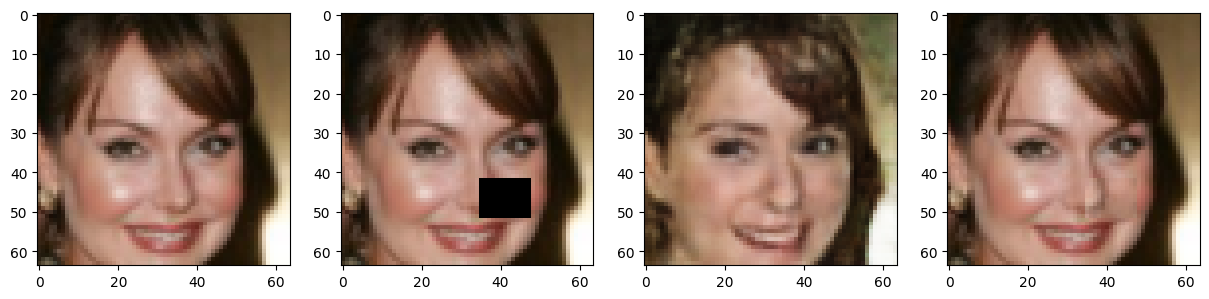

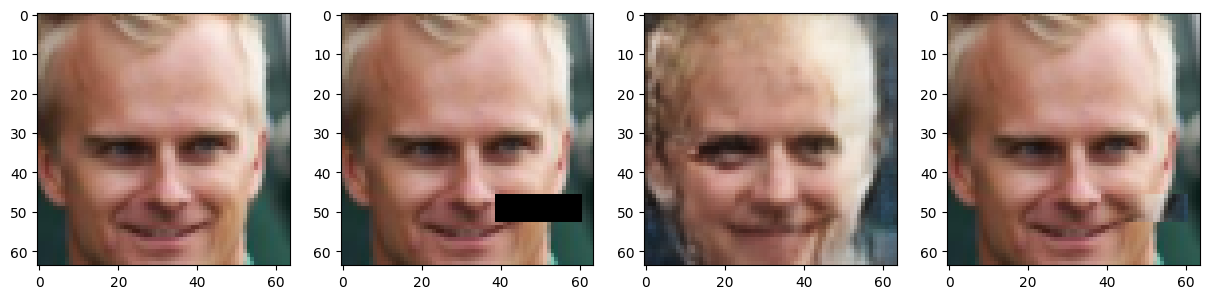

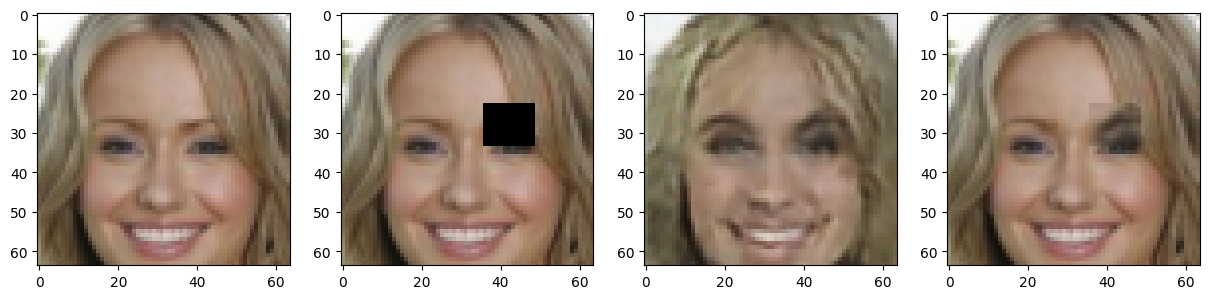

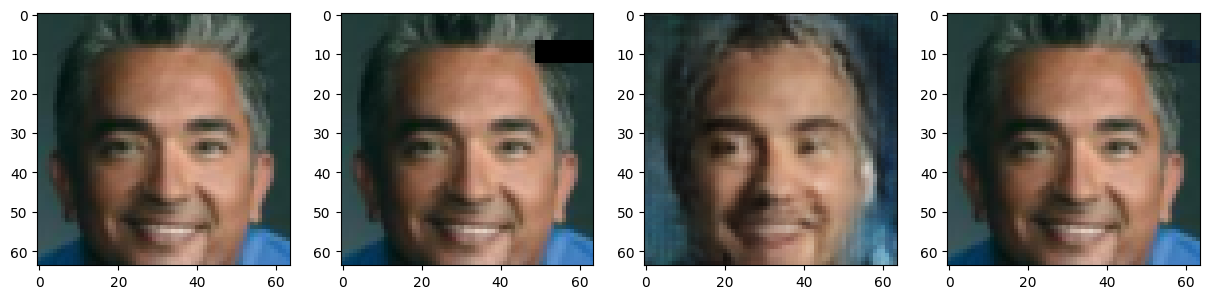

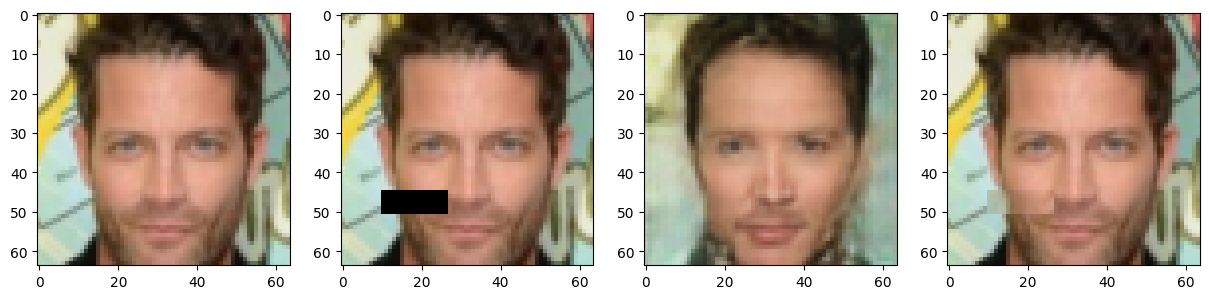

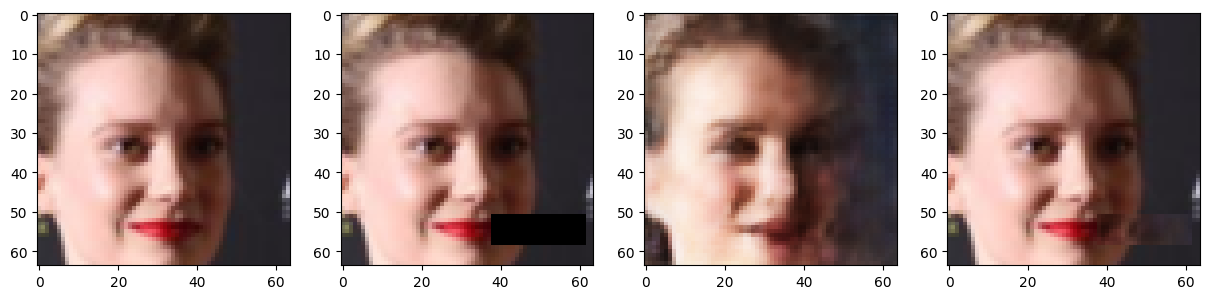

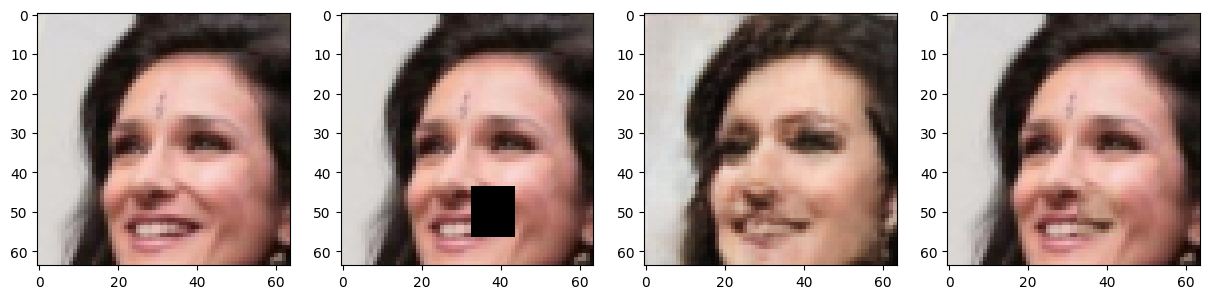

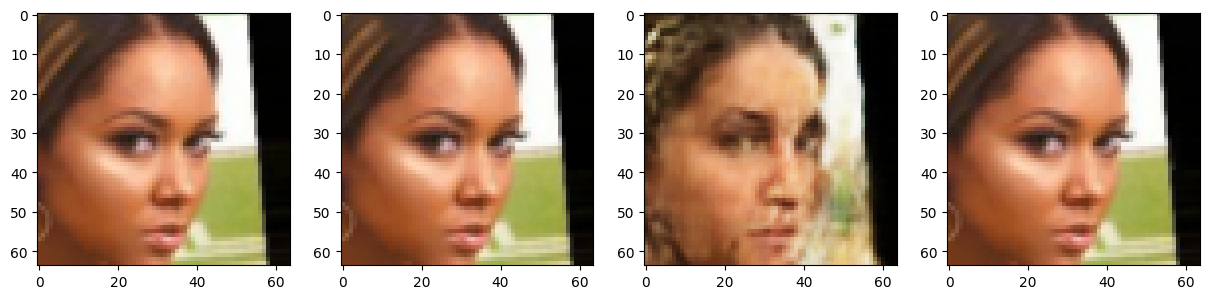

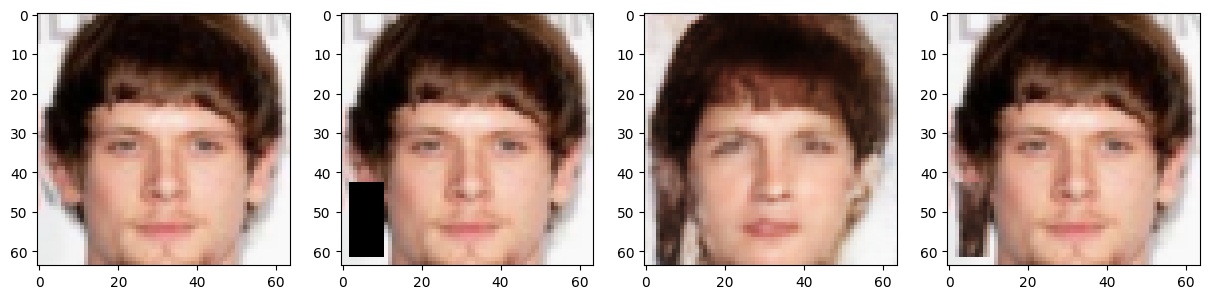

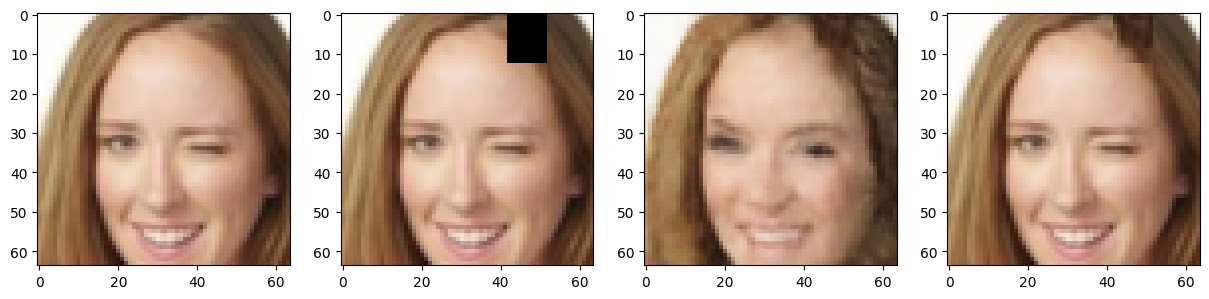

In [80]:
# cVAE finetuned with adversarial loss

model = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/cVAE2_finetuned-epoch8.pt", map_location=device)
model.load_state_dict(checkpoint["net"])
model.to(device)
model.eval()

deletion = DeleteRandomRectangle()

for img_index in [8,12,53,1256,1212,99,231,613,71316,131313]:
    display_reconstruction(model, img_index, deletion, labels=[0])